In [55]:
import os
import json
import datetime
import shutil
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, Lambda, GlobalAveragePooling2D, concatenate
from tensorflow.keras.layers import UpSampling2D, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageOps
from tqdm import tqdm

In [56]:
# Reset all stats generated by keras in the memory
clear_output()

In [57]:
# Enable GPU
#%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [58]:
# Connect to goolge drive and authenticate
# from google.colab import drive
# drive.mount('/content/drive')

# Constants

In [59]:
TRAIN_IMG_MAIS_1 = 'Development_Dataset/Training/Bipbip/Mais/Images'
TRAIN_IMG_HARICOT_1 = 'Development_Dataset/Training/Bipbip/Haricot/Images'
TRAIN_MASK_MAIS_1 = 'Development_Dataset/Training/Bipbip/Mais/Masks'
TRAIN_MASK_HARICOT_1 = 'Development_Dataset/Training/Bipbip/Haricot/Masks'
TEST_IMG_MAIS_1 = 'Development_Dataset/Test_Dev/Bipbip/Mais/Images'
TEST_IMG_HARICOT_1 = 'Development_Dataset/Test_Dev/Bipbip/Haricot/Images'

TRAIN_IMG_MAIS_2 = 'Development_Dataset/Training/Pead/Mais/Images'
TRAIN_IMG_HARICOT_2 = 'Development_Dataset/Training/Pead/Haricot/Images'
TRAIN_MASK_MAIS_2 = 'Development_Dataset/Training/Pead/Mais/Masks'
TRAIN_MASK_HARICOT_2 = 'Development_Dataset/Training/Pead/Haricot/Masks'
TEST_IMG_MAIS_2 = 'Development_Dataset/Test_Dev/Pead/Mais/Images'
TEST_IMG_HARICOT_2 = 'Development_Dataset/Test_Dev/Pead/Haricot/Images'

TRAIN_IMG_MAIS_3 = 'Development_Dataset/Training/Roseau/Mais/Images'
TRAIN_IMG_HARICOT_3 = 'Development_Dataset/Training/Roseau/Haricot/Images'
TRAIN_MASK_MAIS_3 = 'Development_Dataset/Training/Roseau/Mais/Masks'
TRAIN_MASK_HARICOT_3 = 'Development_Dataset/Training/Roseau/Haricot/Masks'
TEST_IMG_MAIS_3 = 'Development_Dataset/Test_Dev/Roseau/Mais/Images'
TEST_IMG_HARICOT_3 = 'Development_Dataset/Test_Dev/Roseau/Haricot/Images'

TRAIN_IMG_MAIS_4 = 'Development_Dataset/Training/Weedelec/Mais/Images'
TRAIN_IMG_HARICOT_4 = 'Development_Dataset/Training/Weedelec/Haricot/Images'
TRAIN_MASK_MAIS_4 = 'Development_Dataset/Training/Weedelec/Mais/Masks'
TRAIN_MASK_HARICOT_4 = 'Development_Dataset/Training/Weedelec/Haricot/Masks'
TEST_IMG_MAIS_4 = 'Development_Dataset/Test_Dev/Weedelec/Mais/Images'
TEST_IMG_HARICOT_4 = 'Development_Dataset/Test_Dev/Weedelec/Haricot/Images'

SEED = 123
TOTAL = 720
BATCH_SIZE = 2
IMAGE_WIDTH = 2048
IMAGE_HEIGHT = 1536
VALIDATION_SPLIT = 0.2
#BUFFER_SIZE = 30
TRAIN_LENGTH = int(TOTAL*(1 - VALIDATION_SPLIT))
VALIDATION_LENGTH = int(TOTAL * VALIDATION_SPLIT)
OUTPUT_CHANNELS = 3
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
EPOCHS = 20
VALIDATION_STEPS = VALIDATION_LENGTH//BATCH_SIZE

# Data

## Data Importing

In [60]:
# copy the data to google colab

zip_data = 'Development_Dataset.zip'
if not os.path.exists("Development_Dataset"):
    !unzip -q Development_Dataset.zip
    print('Done')

In [61]:
if not os.path.exists("Masks"):
    !mkdir -p Masks/Haricot
    !mkdir -p Masks/Mais
    !mv Development_Dataset/Training/Bipbip/Haricot/Masks/* Masks/Haricot
    !mv Development_Dataset/Training/Bipbip/Mais/Masks/* Masks/Mais
    !mv Development_Dataset/Training/Pead/Haricot/Masks/* Masks/Haricot
    !mv Development_Dataset/Training/Pead/Mais/Masks/* Masks/Mais
    !mv Development_Dataset/Training/Roseau/Haricot/Masks/* Masks/Haricot
    !mv Development_Dataset/Training/Roseau/Mais/Masks/* Masks/Mais
    !mv Development_Dataset/Training/Weedelec/Haricot/Masks/* Masks/Haricot
    !mv Development_Dataset/Training/Weedelec/Mais/Masks/* Masks/Mais

if not os.path.exists("Images"):
    !mkdir -p Images/Haricot
    !mkdir -p Images/Mais
    !mv Development_Dataset/Training/Bipbip/Haricot/Images/* Images/Haricot
    !mv Development_Dataset/Training/Bipbip/Mais/Images/* Images/Mais
    !mv Development_Dataset/Training/Pead/Haricot/Images/* Images/Haricot
    !mv Development_Dataset/Training/Pead/Mais/Images/* Images/Mais
    !mv Development_Dataset/Training/Roseau/Haricot/Images/* Images/Haricot
    !mv Development_Dataset/Training/Roseau/Mais/Images/* Images/Mais
    !mv Development_Dataset/Training/Weedelec/Haricot/Images/* Images/Haricot
    !mv Development_Dataset/Training/Weedelec/Mais/Images/* Images/Mais
    
if not os.path.exists("Test"):
    !mkdir -p Test/Images
    !mv Development_Dataset/Test_Dev/Bipbip/Haricot/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Pead/Haricot/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Roseau/Haricot/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Weedelec/Haricot/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Bipbip/Mais/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Pead/Mais/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Roseau/Mais/Images/* Test/Images
    !mv Development_Dataset/Test_Dev/Weedelec/Mais/Images/* Test/Images

## Data Pre-processing

In [62]:
def read_rgb_mask(img_path, width=IMAGE_WIDTH, height=IMAGE_HEIGHT):
  '''
  img_path: path to the mask file
  Returns the numpy array containing target values
  '''
  mask_img = Image.open(img_path)
  mask_arr = np.array(mask_img)

  new_mask_arr = np.zeros(mask_arr.shape[:2], dtype=mask_arr.dtype)

  # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
  new_mask_arr[np.where(np.all(mask_arr == [0, 0, 0], axis=-1))] = 0 #background
  new_mask_arr[np.where(np.all(mask_arr == [254, 124, 18], axis=-1))] = 0 #background
  new_mask_arr[np.where(np.all(mask_arr == [255, 255, 255], axis=-1))] = 1 #crop
  new_mask_arr[np.where(np.all(mask_arr == [216, 67, 82], axis=-1))] = 2 #weed
  new_mask_arr = cv2.resize(new_mask_arr, (width, height))

  return new_mask_arr[:, : , tf.newaxis]

In [63]:
def image_to_array(dir, width=IMAGE_WIDTH, height=IMAGE_HEIGHT):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in tqdm(files):
    img = cv2.imread(os.path.join(dir, filename)).astype('uint8')
    img = cv2.resize(img, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    data.append(img)

  return np.array(data)

In [64]:
def masks_to_array(dir):
  data = []
  files = os.listdir(dir)
  files.sort()
  for filename in tqdm(files):
    data.append(read_rgb_mask(os.path.join(dir, filename)))

  return np.array(data)

## Train & Validation Split

In [65]:
def convert_mask(mask):
    new_mask = np.zeros(mask.shape[:2])
   
    # Use RGB dictionary in 'RGBtoTarget.txt' to convert RGB to target
    new_mask[np.where(np.all(mask == [0, 0, 0], axis=-1))] = 0 #background
    new_mask[np.where(np.all(mask == [151, 151, 151], axis=-1))] = 0 #background
    new_mask[np.where(np.all(mask == [255, 255, 255], axis=-1))] = 1 #crop
    new_mask[np.where(np.all(mask == [113, 113, 113], axis=-1))] = 2 #weed
    
    return new_mask[:, :, tf.newaxis]

In [66]:
data_gen_args = dict(
    validation_split=VALIDATION_SPLIT,
#     featurewise_center=True,
#     width_shift_range = 0.1,
#     height_shift_range = 0.1,
#     horizontal_flip=True,
#     vertical_flip=True,
#     zoom_range = 0.1,
    rescale=1/255,
    dtype='float16'
)
data_flow_args = dict(
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    seed=SEED,
    class_mode=None
)

image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(dtype=tf.uint8, validation_split=VALIDATION_SPLIT, preprocessing_function=convert_mask)

image_generator = image_datagen.flow_from_directory(
    './Images',
    subset="training",
    **data_flow_args
)

image_val_generator = image_datagen.flow_from_directory(
    './Images',
    subset="validation",
    **data_flow_args
)

mask_generator = mask_datagen.flow_from_directory(
    './Masks',
    subset="training",
    color_mode="grayscale",
    **data_flow_args
)

mask_val_generator = mask_datagen.flow_from_directory(
    './Masks',
    subset="validation",
    color_mode="grayscale",
    **data_flow_args,
)

image_test_generator = ImageDataGenerator(
    preprocessing_function=parse_func,
    dtype='uint8').flow_from_directory(
    './Test',
    batch_size=BATCH_SIZE,
    target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
    class_mode=None,
    shuffle=False
)

train_generator = zip(image_generator, mask_generator)
val_generator = zip(image_val_generator, mask_val_generator)

Found 576 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 576 images belonging to 2 classes.
Found 144 images belonging to 2 classes.
Found 120 images belonging to 1 classes.


In [67]:
# class ArtificialDataset(tf.data.Dataset):
#     def _generator(num_samples):
#         # Opening the file
#         time.sleep(0.03)

#         for sample_idx in range(num_samples):
#             # Reading data (line, record) from the file
#             time.sleep(0.015)

#             yield (sample_idx,)

#     def __new__(cls, num_samples=3):
#         return tf.data.Dataset.from_generator(
#             cls._generator,
#             output_types=tf.dtypes.int64,
#             output_shapes=(1,),
#             args=(num_samples,)
#         )

## Data Visualization

In [68]:
def my_display(display_list):
  plt.figure(figsize=(20, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

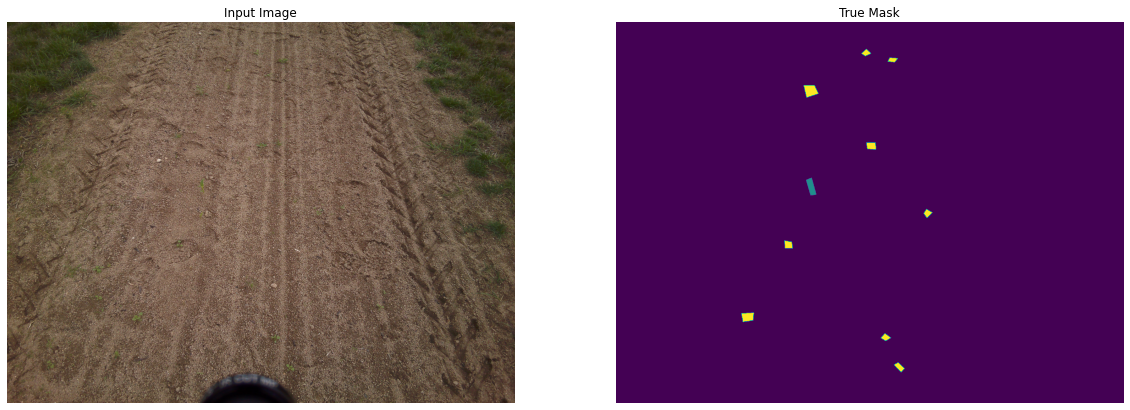

In [69]:
my_display([image_generator[0][0], mask_generator[0][0]])

# Model

## Model Build

In [70]:
# load model and specify a new input shape for images
new_input = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3))
vgg_model = tf.keras.applications.VGG16(include_top=False, input_tensor=new_input, classes=3)

# Use the outputs of these layers
layer_names = [
    'block1_conv2',
    'block2_conv2',
    'block3_conv3',
    'block4_conv3',
    'block5_conv3'
]

layers = [vgg_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=vgg_model.input, outputs=layers)

down_stack.trainable = False
down_stack.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1536, 2048, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 1536, 2048, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 1536, 2048, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 768, 1024, 64)     0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 768, 1024, 128)    73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 768, 1024, 128)    147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 384, 512, 128)     0     

In [71]:
#Add the fully-connected layers
fcn8 = Conv2DTranspose(filters=layers[4].get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn8")

# fcn8 = tf.add(fcn8, layers['block5_conv1'], name="fcn8_plus_vgg_layer5")

fcn9 = Conv2DTranspose(filters=layers[3].get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn9")

# fcn9 = tf.add(fcn9, layers['block4_conv1'], name="fcn9_plus_vgg_layer4")

fcn10 = Conv2DTranspose(filters=layers[2].get_shape().as_list()[-1],
kernel_size=4, strides=(2, 2), padding='SAME', name="fcn10")

# fcn10 = tf.add(fcn10, layers['block3_conv1'], name="fcn10_plus_vgg_layer3")

# fcn11 = Conv2DTranspose(filters=layers[1].get_shape().as_list()[-1],
# kernel_size=4, strides=(2, 2), padding='SAME', name="fcn11")

# fcn11 = tf.add(fcn11, layers['block2_conv1'], name="fcn11_plus_vgg_layer2")

# fcn12 = Conv2DTranspose(filters=layers['block1_conv1'].get_shape().as_list()[-1],
# kernel_size=4, strides=(2, 2), padding='SAME', name="fcn12")(fcn11)

# fcn12 = tf.add(fcn12, layers['block1_conv1'], name="fcn12_plus_vgg_layer1")

# outputs = tf.keras.layers.Conv2DTranspose(
#       3, 3, strides=2,
#       padding='same')(fcn11)

In [72]:
up_stack = [
    fcn8, 
    fcn9,  
    fcn10 
]

In [73]:
def build_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [74]:
model = build_model(3)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1536, 2048,  0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 1536, 2048,  14714688    input_2[0][0]                    
__________________________________________________________________________________________________
fcn8 (Conv2DTranspose)          (None, 192, 256, 512 4194816     model[0][4]                      
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 192, 256, 102 0           fcn8[0][0]                       
                                                                 model[0][3]                

## Callbacks

## Model Training

In [20]:
class MyMeanIOU(tf.keras.metrics.MeanIoU):
  def update_state(self, y_true, y_pred, sample_weight=None):
    return super().update_state(y_true, tf.argmax(y_pred, axis=-1), sample_weight)

In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

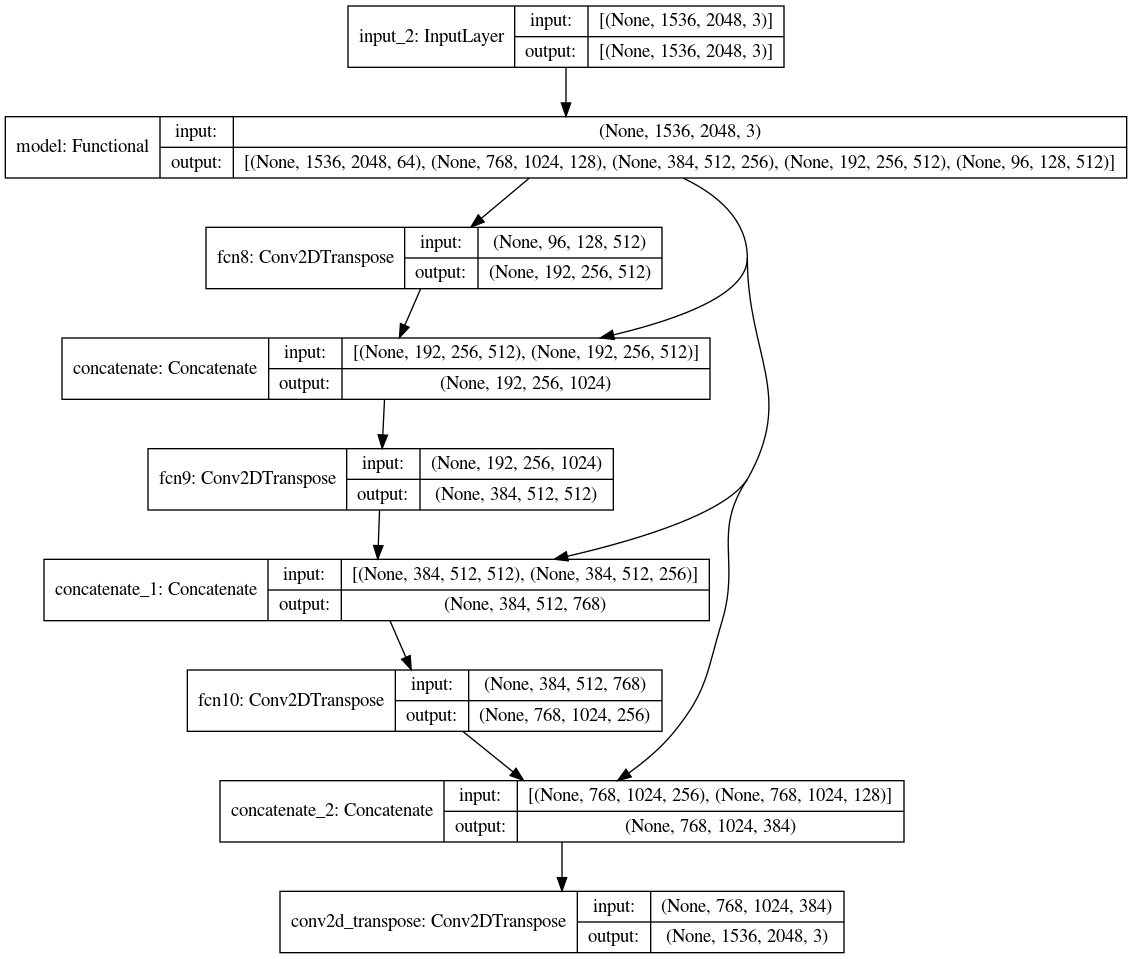

In [22]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [23]:
model_history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    # batch_size=BATCH_SIZE,
    validation_data=val_generator,
    validation_steps=VALIDATION_STEPS
)

Epoch 1/20
30/30 [==============================] - 240s 5s/step - loss: 1.4390 - accuracy: 0.8325 - val_loss: 0.9620 - val_accuracy: 0.8548
Epoch 2/20
30/30 [==============================] - 149s 5s/step - loss: 0.4130 - accuracy: 0.9265 - val_loss: 0.4078 - val_accuracy: 0.8630
Epoch 3/20
30/30 [==============================] - 149s 5s/step - loss: 0.2510 - accuracy: 0.9399 - val_loss: 0.3504 - val_accuracy: 0.8549
Epoch 4/20
30/30 [==============================] - 150s 5s/step - loss: 0.2438 - accuracy: 0.9306 - val_loss: 0.3949 - val_accuracy: 0.9150
Epoch 5/20
30/30 [==============================] - 150s 5s/step - loss: 0.1873 - accuracy: 0.9337 - val_loss: 0.1955 - val_accuracy: 0.8718
Epoch 6/20
30/30 [==============================] - 150s 5s/step - loss: 0.1294 - accuracy: 0.9330 - val_loss: 0.2377 - val_accuracy: 0.8824
Epoch 7/20
30/30 [==============================] - 150s 5s/step - loss: 0.1548 - accuracy: 0.9342 - val_loss: 0.4402 - val_accuracy: 0.8346
Epoch 8/20
30

In [24]:
# Save the model
model.save('model.h5')

## Evaluation & Prediction

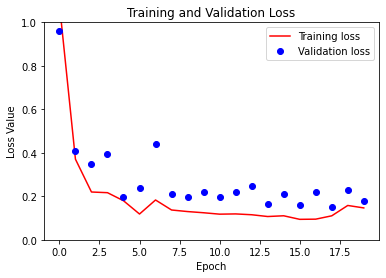

In [25]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [26]:
pred_masks = model.predict(image_test_generator)

In [27]:
def create_mask(pred_mask):
#     pred_mask = pred_mask[:, :, 0]
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask.numpy()

In [28]:
def convert_masks(preds):
    masks = []
    for i in range(len(preds)):
        masks.append(create_mask(preds[i]))
    
    return np.array(masks)

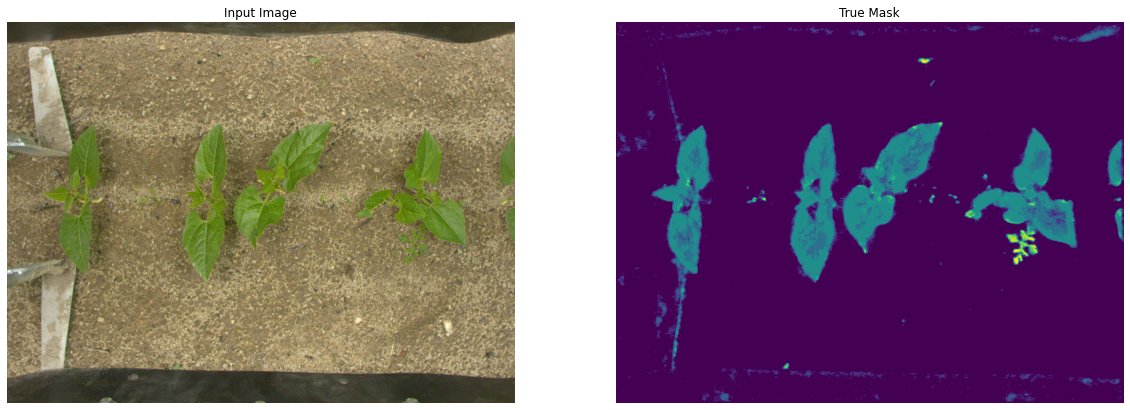

In [29]:
my_display([image_test_generator[0][0], create_mask(pred_masks[0])])

In [30]:
pred_masks = convert_masks(pred_masks)

## IoU

In [31]:
# # keras IoU for 3 classes
# m = tf.keras.metrics.MeanIoU(num_classes=3)
# m.update_state(y_val, val_pred_masks)
# m.result().numpy()

In [32]:
# flat_y = y_val.flatten()
# flat_masks = val_pred_masks.flatten()

In [33]:
# from sklearn.metrics import confusion_matrix

# y_crop = np.where(flat_y == 1, 0, flat_y)
# masks_crop = np.where(flat_masks == 1, 0, flat_masks)
# tn_crop, fp_crop, fn_crop, tp_crop = confusion_matrix(y_crop, masks_crop).ravel()

In [34]:
# IoU_crop = tp_crop / (tp_crop + fp_crop + fn_crop)

In [35]:
# y_weed = np.where(flat_y == 2, 0, flat_y)
# masks_weed = np.where(flat_masks == 2, 0, flat_masks)
# tn_weed, fp_weed, fn_weed, tp_weed = confusion_matrix(y_weed, masks_weed).ravel()

In [36]:
# IoU_weed = tp_weed / (tp_weed + fp_weed + fn_weed)

In [37]:
# # Required IoU for 2 classes
# IoU = (IoU_crop + IoU_weed) / 2
# print(IoU)

# Submission

In [38]:
# Recreate the exact same model, including weights and optimizer.
#model = tf.keras.models.load_model('model.h5')

In [39]:
def rle_encode(img):
    '''
    img: numpy array, 1 - foreground, 0 - background
    Returns run length as string formatted
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


def rle_decode(rle, shape):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

In [40]:
def generate_submission(dir, submission_dict, index, team, crop):
  files = os.listdir(dir)
  files.sort()
  
  for filename in files:
    img_name = os.path.splitext(filename)[0]
    mask_arr = pred_masks[index][:, :, 0]
    index += 1
    
    submission_dict[img_name] = {}
    submission_dict[img_name]['shape'] = mask_arr.shape
    submission_dict[img_name]['team'] = team
    submission_dict[img_name]['crop'] = crop
    submission_dict[img_name]['segmentation'] = {}

    # RLE encoding
    # crop
    rle_encoded_crop = rle_encode(mask_arr == 1)
    # weed
    rle_encoded_weed = rle_encode(mask_arr == 2)

    submission_dict[img_name]['segmentation']['crop'] = rle_encoded_crop
    submission_dict[img_name]['segmentation']['weed'] = rle_encoded_weed

  return submission_dict

In [41]:
submissions = {}
submissions = generate_submission(TEST_IMG_HARICOT_1, submissions, 0, 'Bipbip', 'Haricot')
submissions = generate_submission(TEST_IMG_MAIS_1, submissions, 15, 'Bipbip', 'Mais')
submissions = generate_submission(TEST_IMG_HARICOT_2, submissions, 30, 'Pead', 'Haricot')
submissions = generate_submission(TEST_IMG_MAIS_2, submissions, 45, 'Pead', 'Mais')
submissions = generate_submission(TEST_IMG_HARICOT_3, submissions, 60, 'Roseau', 'Haricot')
submissions = generate_submission(TEST_IMG_MAIS_3, submissions, 75, 'Roseau', 'Mais')
submissions = generate_submission(TEST_IMG_HARICOT_4, submissions, 90, 'Weedelec', 'Haricot')
submissions = generate_submission(TEST_IMG_MAIS_4, submissions, 105, 'Weedelec', 'Mais')
with open('./submission.json', 'w') as f:
    json.dump(submissions, f)

In [42]:
# Read the submission.json file generated by the
# 'prepare_submission.py' script
with open('./submission.json', 'r') as f:
    submission_dict = json.load(f)

files = os.listdir(TEST_IMG_HARICOT_1)
files.sort()
index = 0
for filename in files:
  img_name = os.path.splitext(filename)[0]
  img_shape = submission_dict[img_name]['shape']

  rle_encoded_crop = submission_dict[img_name]['segmentation']['crop']
  rle_encoded_weed = submission_dict[img_name]['segmentation']['weed']

  # Reconstruct crop and weed binary masks
  crop_mask = rle_decode(rle_encoded_crop, shape=img_shape)
  weed_mask = rle_decode(rle_encoded_weed, shape=img_shape)

  # Reconstruct original mask
  # weed_mask * 2 allows to convert ones into target 2 (weed label)
  reconstructed_mask = crop_mask + (weed_mask * 2)

  # Check that the RLE decoded mask is the same of the original mask
  # before the RLE encoding
  original_mask = pred_masks[index][:, :, 0]

  np.testing.assert_allclose(original_mask, reconstructed_mask)

  index += 1

  # Just for visualisation purposes, save RGB reconstructed mask
  # Use again the dictionary in 'RGBtoTarget.txt'.
  reconstructed_rgb_arr = np.zeros(shape=img_shape + [3])
  reconstructed_rgb_arr[reconstructed_mask == 1] = [255, 255, 255]
  reconstructed_rgb_arr[reconstructed_mask == 2] = [216, 67, 82]

  reconstructed_rgb_img = Image.fromarray(
      np.uint8(reconstructed_rgb_arr))
  reconstructed_rgb_img.save(f'./predictions/rle_decoded_rgb_mask_{img_name}.png')

  # Please notice that the 'unknown' class corresponding to the
  # RGB value [216, 124, 18] is not considered for the evaluation
  # and thus does not appear in the reconstructed mask.